In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-paper')

## 1. Read the Dataset

### 1.1 File Info.
- 문서 앱내 사용시 발생하는 클라이언 로그 데이터 (after parsed)
- 서버로그와 달리, 유저의 행동이 발생할 경우 로그 수집 (유저 행동 패턴 파악에 용이)
    - 클라이언트(앱) 로그
    - 서버 로그

In [2]:
df = pd.read_csv("df_funnel.csv", index_col=0)

### 1.2 Columns Info.
- actiontype: 문서 이용시 행동(OPEN, CLOSE, SAVE,,)
- ismydoc: 내문서 해당 여부(중요x)
- ext: 문서 확장자
- sessionid: 유저 식별자
- documentposition: 문서 이용시 위치 정보(CLOUD, OTHERAPP)
- datetime: Timestamp
- screen: 앱내 화면 이름

In [3]:
df.head(5)

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,OPEN,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016.7.18,Per_Dir
1,CLOSE,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016.7.18,Per_Dir
2,OPEN,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016.7.18,Pub_Dir
3,CLOSE,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016.7.18,Pub_Dir
4,OPEN,NoView,PDF,f191063c562691041dfa935ff0876975,OTHERAPP,2016.7.6,Main


In [4]:
df.tail(5)

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
301856,CLOSE,View,XLSX,2ed068d5e6a72e80e4a997c01c59f782,OTHERAPP,2016.7.7,Main
301857,OPEN,NoView,DOCX,41b8c1df291edd2aec30fc610e5b676e,OTHERAPP,2016.7.5,Main
301858,RESET,View,DOCX,41b8c1df291edd2aec30fc610e5b676e,OTHERAPP,2016.7.5,Main
301859,OPEN,NoView,PPT,9b5ee236571c2fcbe25132b6ba71d764,OTHERAPP,2016.7.14,Main
301860,CLOSE,NoView,PPT,9b5ee236571c2fcbe25132b6ba71d764,OTHERAPP,2016.7.14,Main


In [5]:
# key info => data entires, missing values, type
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 301861 entries, 0 to 301860
Data columns (total 7 columns):
actiontype          301861 non-null object
ismydoc             301861 non-null object
ext                 301861 non-null object
sessionid           301861 non-null object
documentposition    301861 non-null object
datetime            301861 non-null object
screen              301861 non-null object
dtypes: object(7)
memory usage: 18.4+ MB


## 2. Preprocessing
- 데이터 타입 변환
- 데이터 값 변경
- 결측치 처리
- 신규 session id 부여
- 대소문자 처리

### 2.1 날짜를 pandas datetime 형태로 변환하기
[Reference](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html)

In [6]:
# if datetime is string? no sort 
df.groupby("datetime").size().head(15)

datetime
2016.7.1     11836
2016.7.10     6750
2016.7.11    10075
2016.7.12    12340
2016.7.13    12159
2016.7.14    11721
2016.7.15    11057
2016.7.16     8513
2016.7.17     6906
2016.7.18     9987
2016.7.19    11872
2016.7.2      8884
2016.7.20    11912
2016.7.21    11599
2016.7.22    11250
dtype: int64

In [7]:
## case 1. if date type is string,
str_date = ['2018/01/01', '2018.01.02', '2018-01-03', '2018-01-04', '2018/01/05'] # string type
str_date

['2018/01/01', '2018.01.02', '2018-01-03', '2018-01-04', '2018/01/05']

In [8]:
pd.to_datetime(str_date) # parsed

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05'],
              dtype='datetime64[ns]', freq=None)

In [9]:
pd.Series(pd.to_datetime(str_date)) # to pd.series

0   2018-01-01
1   2018-01-02
2   2018-01-03
3   2018-01-04
4   2018-01-05
dtype: datetime64[ns]

In [10]:
## case 2. 날짜가 timestamp인 경우
ts_date = [1349720105, 1349806505, 1349892905, 1349979305, 1350065705]
ts_date

[1349720105, 1349806505, 1349892905, 1349979305, 1350065705]

In [11]:
pd.Series(pd.to_datetime([1530837876, 1530751476, 1530665076, 1530578676, 1530492276], unit='s')).dt.date

0    2018-07-06
1    2018-07-05
2    2018-07-04
3    2018-07-03
4    2018-07-02
dtype: object

- timestamp converter: https://www.epochconverter.com/

In [12]:
## case 3. 컬럼 타입만 바꾸는 경우
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 301861 entries, 0 to 301860
Data columns (total 7 columns):
actiontype          301861 non-null object
ismydoc             301861 non-null object
ext                 301861 non-null object
sessionid           301861 non-null object
documentposition    301861 non-null object
datetime            301861 non-null object
screen              301861 non-null object
dtypes: object(7)
memory usage: 18.4+ MB


In [13]:
df.head() # object = string

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,OPEN,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016.7.18,Per_Dir
1,CLOSE,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016.7.18,Per_Dir
2,OPEN,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016.7.18,Pub_Dir
3,CLOSE,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016.7.18,Pub_Dir
4,OPEN,NoView,PDF,f191063c562691041dfa935ff0876975,OTHERAPP,2016.7.6,Main


In [14]:
# option1. string to datetime
df['datetime'].astype('datetime64[ns]').head()

0   2016-07-18
1   2016-07-18
2   2016-07-18
3   2016-07-18
4   2016-07-06
Name: datetime, dtype: datetime64[ns]

In [15]:
# option2.
pd.to_datetime(df['datetime']).head()

0   2016-07-18
1   2016-07-18
2   2016-07-18
3   2016-07-18
4   2016-07-06
Name: datetime, dtype: datetime64[ns]

In [16]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 301861 entries, 0 to 301860
Data columns (total 7 columns):
actiontype          301861 non-null object
ismydoc             301861 non-null object
ext                 301861 non-null object
sessionid           301861 non-null object
documentposition    301861 non-null object
datetime            301861 non-null datetime64[ns]
screen              301861 non-null object
dtypes: datetime64[ns](1), object(6)
memory usage: 18.4+ MB


In [18]:
df.head()

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,OPEN,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
1,CLOSE,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
2,OPEN,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016-07-18,Pub_Dir
3,CLOSE,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016-07-18,Pub_Dir
4,OPEN,NoView,PDF,f191063c562691041dfa935ff0876975,OTHERAPP,2016-07-06,Main


In [19]:
df.groupby("datetime").size()#.plot()

datetime
2016-07-01    11836
2016-07-02     8884
2016-07-03     6334
2016-07-04     9260
2016-07-05    10988
2016-07-06    10525
2016-07-07    10153
2016-07-08    10522
2016-07-09     8283
2016-07-10     6750
2016-07-11    10075
2016-07-12    12340
2016-07-13    12159
2016-07-14    11721
2016-07-15    11057
2016-07-16     8513
2016-07-17     6906
2016-07-18     9987
2016-07-19    11872
2016-07-20    11912
2016-07-21    11599
2016-07-22    11250
2016-07-23     8390
2016-07-24     6813
2016-07-25    10081
2016-07-26    12034
2016-07-27    11593
2016-07-28    11216
2016-07-29    10721
2016-07-30     8087
dtype: int64

- Pandas Datetime API
    - https://pandas.pydata.org/pandas-docs/stable/timeseries.html
    - https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.dt.html

In [31]:
# day to month
df['datetime'].dt.month[:10]

0    7
1    7
2    7
3    7
4    7
5    7
6    7
7    7
8    7
9    7
Name: datetime, dtype: int64

In [32]:
# day to day
df['datetime'].dt.day[:10]

0    18
1    18
2    18
3    18
4     6
5     6
6    20
7    20
8    28
9    28
Name: datetime, dtype: int64

### Task 1. df 데이터 프레임에 새로운 컬럼(요일) 생성
1. df['dayofweek']: 요일 
2. 요일별 로그 수 카운트
3. 요일 컬럼 삭제

### 2.2 Missing value 확인

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 301861 entries, 0 to 301860
Data columns (total 7 columns):
actiontype          301861 non-null object
ismydoc             301861 non-null object
ext                 301861 non-null object
sessionid           301861 non-null object
documentposition    301861 non-null object
datetime            301861 non-null datetime64[ns]
screen              301861 non-null object
dtypes: datetime64[ns](1), object(6)
memory usage: 18.4+ MB


In [37]:
df.isnull().sum()

actiontype          0
ismydoc             0
ext                 0
sessionid           0
documentposition    0
datetime            0
screen              0
dtype: int64

### 2.3 결측치 처리

- **Drop**
    - 경우에 따라 결측치 처리 방법이 달라진다.
    - 샘플수가 많다면 missing values 를 포함하는 행을 모두 삭제하는 것이 가능하다

```python
# 결측치가 하나라도 있으면 버리는 코드 예제
df.dropna()

# 모든 값이 Null일 경우만 버리는 코드 예제
df.dropna(how='all')

# 결측치가 하나 이상 있는 Case만 선택하는 코드 예제
df[df.isnull().any(axis=1)]
```

- **Imputation**
    - 만약 샘플수가 충분하지 않을 경우, Pandas의 fillna() 명령어로 Null 값을 채우는 것이 가능하다. 
    - 연속형인 경우 Mean이나 Median을 이용하고 명목형인 경우 Mode(최빈치)나 예측 모형을 통해 Null 값을 대체할 수 있다.

```python
# Null 값을 median으로 대체하는 코드 예제
df.fillna(df.mean()) 
```

- **Reference**
    - https://machinelearningmastery.com/handle-missing-data-python/

In [38]:
df_by_screen = df.groupby(["datetime", "screen"])['sessionid'].nunique().unstack()

df_by_screen[:10]

screen,InProduct_Mob,InProduct_Web,Main,Per_Dir,Pub_Dir,Purchase_done,Purchase_page
datetime,,,,,,,
2016-07-01,137.0,147.0,3582.0,296.0,1008.0,2.0,23.0
2016-07-02,89.0,124.0,2683.0,206.0,801.0,2.0,15.0
2016-07-03,50.0,83.0,1886.0,165.0,590.0,NaN,28.0
2016-07-04,112.0,104.0,2808.0,281.0,764.0,NaN,29.0
2016-07-05,118.0,138.0,3335.0,300.0,842.0,1.0,26.0
2016-07-06,138.0,145.0,3256.0,293.0,855.0,1.0,30.0
2016-07-07,110.0,117.0,3150.0,266.0,807.0,NaN,18.0
2016-07-08,117.0,148.0,3208.0,273.0,865.0,2.0,20.0
2016-07-09,102.0,138.0,2381.0,229.0,748.0,2.0,23.0


In [39]:
df_by_screen.isnull().sum()

screen
InProduct_Mob    0
InProduct_Web    0
Main             0
Per_Dir          0
Pub_Dir          0
Purchase_done    6
Purchase_page    0
dtype: int64

In [40]:
df_by_screen.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30 entries, 2016-07-01 to 2016-07-30
Data columns (total 7 columns):
InProduct_Mob    30 non-null float64
InProduct_Web    30 non-null float64
Main             30 non-null float64
Per_Dir          30 non-null float64
Pub_Dir          30 non-null float64
Purchase_done    24 non-null float64
Purchase_page    30 non-null float64
dtypes: float64(7)
memory usage: 1.9 KB


- 비즈니스 맥락 및 목적(퍼널분석)을 고려했을 때, 이 경우는 결측치를 0으로 처리하는 것이 적당함

In [41]:
df_by_screen.fillna(0)[:10]

screen,InProduct_Mob,InProduct_Web,Main,Per_Dir,Pub_Dir,Purchase_done,Purchase_page
datetime,,,,,,,
2016-07-01,137.0,147.0,3582.0,296.0,1008.0,2.0,23.0
2016-07-02,89.0,124.0,2683.0,206.0,801.0,2.0,15.0
2016-07-03,50.0,83.0,1886.0,165.0,590.0,0.0,28.0
2016-07-04,112.0,104.0,2808.0,281.0,764.0,0.0,29.0
2016-07-05,118.0,138.0,3335.0,300.0,842.0,1.0,26.0
2016-07-06,138.0,145.0,3256.0,293.0,855.0,1.0,30.0
2016-07-07,110.0,117.0,3150.0,266.0,807.0,0.0,18.0
2016-07-08,117.0,148.0,3208.0,273.0,865.0,2.0,20.0
2016-07-09,102.0,138.0,2381.0,229.0,748.0,2.0,23.0


In [42]:
# dropna with 'how' param
df_by_screen.dropna(how='any')[:10] # how='all' or 'any'

screen,InProduct_Mob,InProduct_Web,Main,Per_Dir,Pub_Dir,Purchase_done,Purchase_page
datetime,,,,,,,
2016-07-01,137.0,147.0,3582.0,296.0,1008.0,2.0,23.0
2016-07-02,89.0,124.0,2683.0,206.0,801.0,2.0,15.0
2016-07-05,118.0,138.0,3335.0,300.0,842.0,1.0,26.0
2016-07-06,138.0,145.0,3256.0,293.0,855.0,1.0,30.0
2016-07-08,117.0,148.0,3208.0,273.0,865.0,2.0,20.0
2016-07-09,102.0,138.0,2381.0,229.0,748.0,2.0,23.0
2016-07-10,62.0,122.0,1872.0,230.0,636.0,2.0,18.0
2016-07-12,138.0,157.0,3646.0,371.0,1000.0,4.0,26.0
2016-07-13,132.0,172.0,3544.0,334.0,988.0,1.0,35.0


In [43]:
df_by_screen.dropna(how='all')[:10] # how='all' or 'any'

screen,InProduct_Mob,InProduct_Web,Main,Per_Dir,Pub_Dir,Purchase_done,Purchase_page
datetime,,,,,,,
2016-07-01,137.0,147.0,3582.0,296.0,1008.0,2.0,23.0
2016-07-02,89.0,124.0,2683.0,206.0,801.0,2.0,15.0
2016-07-03,50.0,83.0,1886.0,165.0,590.0,NaN,28.0
2016-07-04,112.0,104.0,2808.0,281.0,764.0,NaN,29.0
2016-07-05,118.0,138.0,3335.0,300.0,842.0,1.0,26.0
2016-07-06,138.0,145.0,3256.0,293.0,855.0,1.0,30.0
2016-07-07,110.0,117.0,3150.0,266.0,807.0,NaN,18.0
2016-07-08,117.0,148.0,3208.0,273.0,865.0,2.0,20.0
2016-07-09,102.0,138.0,2381.0,229.0,748.0,2.0,23.0


In [44]:
# select ony rows, including NaN
df_by_screen[df_by_screen.isnull().any(axis=1)]

screen,InProduct_Mob,InProduct_Web,Main,Per_Dir,Pub_Dir,Purchase_done,Purchase_page
datetime,,,,,,,
2016-07-03,50.0,83.0,1886.0,165.0,590.0,NaN,28.0
2016-07-04,112.0,104.0,2808.0,281.0,764.0,NaN,29.0
2016-07-07,110.0,117.0,3150.0,266.0,807.0,NaN,18.0
2016-07-11,125.0,139.0,2944.0,332.0,801.0,NaN,26.0
2016-07-18,133.0,162.0,2882.0,317.0,841.0,NaN,30.0
2016-07-19,124.0,137.0,3552.0,331.0,934.0,NaN,24.0


In [45]:
# fill NaN with median
df_by_screen.fillna(df_by_screen.median())[:10] # mean, max, min ..

screen,InProduct_Mob,InProduct_Web,Main,Per_Dir,Pub_Dir,Purchase_done,Purchase_page
datetime,,,,,,,
2016-07-01,137.0,147.0,3582.0,296.0,1008.0,2.0,23.0
2016-07-02,89.0,124.0,2683.0,206.0,801.0,2.0,15.0
2016-07-03,50.0,83.0,1886.0,165.0,590.0,2.0,28.0
2016-07-04,112.0,104.0,2808.0,281.0,764.0,2.0,29.0
2016-07-05,118.0,138.0,3335.0,300.0,842.0,1.0,26.0
2016-07-06,138.0,145.0,3256.0,293.0,855.0,1.0,30.0
2016-07-07,110.0,117.0,3150.0,266.0,807.0,2.0,18.0
2016-07-08,117.0,148.0,3208.0,273.0,865.0,2.0,20.0
2016-07-09,102.0,138.0,2381.0,229.0,748.0,2.0,23.0


### 2.4 결측치가 카테고리 변수인 경우
- Option 1. 최빈치(mode)
    - 쉽고 빠르게 이용가능하나, 낮은 적절성
- Option 2. 예측모형으로 예측치
    - 적절성은 비교적 높으나 별도의 모형과 계산량 필요

In [46]:
df.head(10)

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,OPEN,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
1,CLOSE,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
2,OPEN,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016-07-18,Pub_Dir
3,CLOSE,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016-07-18,Pub_Dir
4,OPEN,NoView,PDF,f191063c562691041dfa935ff0876975,OTHERAPP,2016-07-06,Main
5,RESET,View,PDF,f191063c562691041dfa935ff0876975,OTHERAPP,2016-07-06,Main
6,CLOSE,NoView,PDF,3747719d8f6bdd334703320433928d5a,OTHERAPP,2016-07-20,Main
7,OPEN,NoView,PDF,3747719d8f6bdd334703320433928d5a,OTHERAPP,2016-07-20,Main
8,OPEN,NoView,PDF,3da5ab986c93803de1e25012d9972274,OTHERAPP,2016-07-28,Main
9,CLOSE,NoView,PDF,3da5ab986c93803de1e25012d9972274,OTHERAPP,2016-07-28,Main


In [47]:
df_ms = df.copy() # it helps to test any code or functions

df_ms.ix[2, 'documentposition'] = np.nan
df_ms.ix[5, 'documentposition'] = np.nan
df_ms.ix[7, 'documentposition'] = np.nan
df_ms.ix[10, 'documentposition'] = np.nan
df_ms.ix[11, 'documentposition'] = np.nan
df_ms.ix[15, 'documentposition'] = np.nan

In [48]:
df_ms.head(10)

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,OPEN,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
1,CLOSE,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
2,OPEN,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,NaN,2016-07-18,Pub_Dir
3,CLOSE,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016-07-18,Pub_Dir
4,OPEN,NoView,PDF,f191063c562691041dfa935ff0876975,OTHERAPP,2016-07-06,Main
5,RESET,View,PDF,f191063c562691041dfa935ff0876975,NaN,2016-07-06,Main
6,CLOSE,NoView,PDF,3747719d8f6bdd334703320433928d5a,OTHERAPP,2016-07-20,Main
7,OPEN,NoView,PDF,3747719d8f6bdd334703320433928d5a,NaN,2016-07-20,Main
8,OPEN,NoView,PDF,3da5ab986c93803de1e25012d9972274,OTHERAPP,2016-07-28,Main
9,CLOSE,NoView,PDF,3da5ab986c93803de1e25012d9972274,OTHERAPP,2016-07-28,Main


In [49]:
# frequency table
df_ms.documentposition.value_counts()

OTHERAPP          213775
MYPOLARISDRIVE     55518
LOCALSTORAGE       18922
NEWDOCUMENT         7612
NONE                4335
OTHERCLOUD          1617
SHAREDDOCUMENT        76
Name: documentposition, dtype: int64

In [50]:
# fillna with most frequent value (MODE)
freq_values = df_ms.documentposition.value_counts().index[0]

freq_values

'OTHERAPP'

In [51]:
df_ms['documentposition'] = df_ms['documentposition'].fillna(freq_values)

In [52]:
df_ms.head(10)

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,OPEN,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
1,CLOSE,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
2,OPEN,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,OTHERAPP,2016-07-18,Pub_Dir
3,CLOSE,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016-07-18,Pub_Dir
4,OPEN,NoView,PDF,f191063c562691041dfa935ff0876975,OTHERAPP,2016-07-06,Main
5,RESET,View,PDF,f191063c562691041dfa935ff0876975,OTHERAPP,2016-07-06,Main
6,CLOSE,NoView,PDF,3747719d8f6bdd334703320433928d5a,OTHERAPP,2016-07-20,Main
7,OPEN,NoView,PDF,3747719d8f6bdd334703320433928d5a,OTHERAPP,2016-07-20,Main
8,OPEN,NoView,PDF,3da5ab986c93803de1e25012d9972274,OTHERAPP,2016-07-28,Main
9,CLOSE,NoView,PDF,3da5ab986c93803de1e25012d9972274,OTHERAPP,2016-07-28,Main


In [53]:
# let's use a machine learning model to deal with nulls
df_ms.ix[2, 'documentposition'] = np.nan
df_ms.ix[5, 'documentposition'] = np.nan
df_ms.ix[7, 'documentposition'] = np.nan
df_ms.ix[10, 'documentposition'] = np.nan
df_ms.ix[11, 'documentposition'] = np.nan
df_ms.ix[15, 'documentposition'] = np.nan

df_ms.head(10)

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,OPEN,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
1,CLOSE,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
2,OPEN,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,NaN,2016-07-18,Pub_Dir
3,CLOSE,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016-07-18,Pub_Dir
4,OPEN,NoView,PDF,f191063c562691041dfa935ff0876975,OTHERAPP,2016-07-06,Main
5,RESET,View,PDF,f191063c562691041dfa935ff0876975,NaN,2016-07-06,Main
6,CLOSE,NoView,PDF,3747719d8f6bdd334703320433928d5a,OTHERAPP,2016-07-20,Main
7,OPEN,NoView,PDF,3747719d8f6bdd334703320433928d5a,NaN,2016-07-20,Main
8,OPEN,NoView,PDF,3da5ab986c93803de1e25012d9972274,OTHERAPP,2016-07-28,Main
9,CLOSE,NoView,PDF,3da5ab986c93803de1e25012d9972274,OTHERAPP,2016-07-28,Main


In [54]:
# fill na using predictive model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# train without na
df_ms1 = df_ms.dropna()

# set independent cols
ind_cols = ['actiontype', 'ismydoc', 'ext', 'screen']

# split ind, tar
X = df_ms1[ind_cols]
y = df_ms1[['documentposition']]

In [55]:
X.head(10) # independent vars

,actiontype,ismydoc,ext,screen
0,OPEN,NoView,PDF,Per_Dir
1,CLOSE,NoView,PDF,Per_Dir
3,CLOSE,View,PDF,Pub_Dir
4,OPEN,NoView,PDF,Main
6,CLOSE,NoView,PDF,Main
8,OPEN,NoView,PDF,Main
9,CLOSE,NoView,PDF,Main
12,CLOSE,NoView,PDF,Main
13,RESET,View,PDF,Main
14,OPEN,View,PDF,Pub_Dir


In [56]:
y[:10] # target vars

,documentposition
0,LOCALSTORAGE
1,LOCALSTORAGE
3,MYPOLARISDRIVE
4,OTHERAPP
6,OTHERAPP
8,OTHERAPP
9,OTHERAPP
12,OTHERAPP
13,OTHERAPP
14,MYPOLARISDRIVE


In [57]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

X = X.apply(lambda x: encoder.fit_transform(x))
y = y.apply(lambda y: encoder.fit_transform(y))

In [58]:
X.head(10)

,actiontype,ismydoc,ext,screen
0,3,0,5,3
1,0,0,5,3
3,0,1,5,4
4,3,0,5,2
6,0,0,5,2
8,3,0,5,2
9,0,0,5,2
12,0,0,5,2
13,4,1,5,2
14,3,1,5,4


In [59]:
y[:10]

,documentposition
0,0
1,0
3,1
4,4
6,4
8,4
9,4
12,4
13,4
14,1


In [60]:
## the cross validation phase
# X: df_ms_ind / y: df_ms_tar

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

In [61]:
print(X.shape)
print(y.shape)

(301855, 4)
(301855, 1)


In [62]:
print(X_train.shape, y_train.shape)

((226391, 4), (226391, 1))


In [63]:
print(X_test.shape, y_test.shape)

((75464, 4), (75464, 1))


[KNN Algorithm](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)
![img](https://i0.wp.com/adataanalyst.com/wp-content/uploads/2016/07/kNN-1.png?)

In [64]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)

knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [66]:
print(knn.score(X_train, y_train)) # score 의미?

0.9998719030350146


In [67]:
print(knn.score(X_test, y_test))

0.9997879783737941


In [68]:
knn_pred = knn.predict(X_test)
knn_pred[:20]

array([1, 4, 4, 4, 4, 1, 4, 1, 4, 4, 4, 2, 4, 1, 4, 0, 4, 1, 4, 4])

In [69]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, knn_pred))

[[ 4733     0     0     0     3     0     0]
 [    2 13895     0     0     0     0     0]
 [    0     0  1920     0     3     0     0]
 [    0     0     2  1085     0     0     0]
 [    1     0     1     0 53383     0     0]
 [    0     1     0     0     0   413     0]
 [    0     3     0     0     0     0    19]]


In [70]:
from sklearn.metrics import classification_report

print(classification_report(y_test, knn_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      4736
          1       1.00      1.00      1.00     13897
          2       1.00      1.00      1.00      1923
          3       1.00      1.00      1.00      1087
          4       1.00      1.00      1.00     53385
          5       1.00      1.00      1.00       414
          6       1.00      0.86      0.93        22

avg / total       1.00      1.00      1.00     75464



In [71]:
pd.Series(knn_pred).value_counts().sort_index()

0     4736
1    13899
2     1923
3     1085
4    53389
5      413
6       19
dtype: int64

In [72]:
class_cd = pd.Series(encoder.classes_).to_dict()

class_cd

{0: 'LOCALSTORAGE',
 1: 'MYPOLARISDRIVE',
 2: 'NEWDOCUMENT',
 3: 'NONE',
 4: 'OTHERAPP',
 5: 'OTHERCLOUD',
 6: 'SHAREDDOCUMENT'}

In [73]:
# let's impute the null values with the knn predictive model
df_ms.head(10)

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,OPEN,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
1,CLOSE,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
2,OPEN,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,NaN,2016-07-18,Pub_Dir
3,CLOSE,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016-07-18,Pub_Dir
4,OPEN,NoView,PDF,f191063c562691041dfa935ff0876975,OTHERAPP,2016-07-06,Main
5,RESET,View,PDF,f191063c562691041dfa935ff0876975,NaN,2016-07-06,Main
6,CLOSE,NoView,PDF,3747719d8f6bdd334703320433928d5a,OTHERAPP,2016-07-20,Main
7,OPEN,NoView,PDF,3747719d8f6bdd334703320433928d5a,NaN,2016-07-20,Main
8,OPEN,NoView,PDF,3da5ab986c93803de1e25012d9972274,OTHERAPP,2016-07-28,Main
9,CLOSE,NoView,PDF,3da5ab986c93803de1e25012d9972274,OTHERAPP,2016-07-28,Main


In [74]:
df_ms.isnull().sum()

actiontype          0
ismydoc             0
ext                 0
sessionid           0
documentposition    6
datetime            0
screen              0
dtype: int64

In [75]:
df_ms_only = df_ms[df_ms.isnull().any(axis=1)]

df_ms_only

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
2,OPEN,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,NaN,2016-07-18,Pub_Dir
5,RESET,View,PDF,f191063c562691041dfa935ff0876975,NaN,2016-07-06,Main
7,OPEN,NoView,PDF,3747719d8f6bdd334703320433928d5a,NaN,2016-07-20,Main
10,OPEN,View,PDF,3da5ab986c93803de1e25012d9972274,NaN,2016-07-28,Main
11,OPEN,NoView,PDF,9e37751e132b5eb96e7d3fde7db132e3,NaN,2016-07-19,Main
15,CLOSE,View,PDF,450e74586e6a05f2983905205e8f8cb1,NaN,2016-07-24,Pub_Dir


In [76]:
df_ms_dropna = df_ms.dropna()

df_ms_dropna.head()

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,OPEN,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
1,CLOSE,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
3,CLOSE,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016-07-18,Pub_Dir
4,OPEN,NoView,PDF,f191063c562691041dfa935ff0876975,OTHERAPP,2016-07-06,Main
6,CLOSE,NoView,PDF,3747719d8f6bdd334703320433928d5a,OTHERAPP,2016-07-20,Main


In [77]:
# predict missing categorical vars
knn.predict(df_ms_only[ind_cols].apply(lambda x: encoder.fit_transform(x)))

array([2, 2, 3, 3, 3, 3])

In [78]:
class_cd

{0: 'LOCALSTORAGE',
 1: 'MYPOLARISDRIVE',
 2: 'NEWDOCUMENT',
 3: 'NONE',
 4: 'OTHERAPP',
 5: 'OTHERCLOUD',
 6: 'SHAREDDOCUMENT'}

In [79]:
fill_na_values = knn.predict(df_ms_only[ind_cols].apply(lambda x: encoder.fit_transform(x)))

fill_na_values

array([2, 2, 3, 3, 3, 3])

In [80]:
df_ms_only['documentposition'] = fill_na_values

In [81]:
df_ms_only.head(10)

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
2,OPEN,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,2,2016-07-18,Pub_Dir
5,RESET,View,PDF,f191063c562691041dfa935ff0876975,2,2016-07-06,Main
7,OPEN,NoView,PDF,3747719d8f6bdd334703320433928d5a,3,2016-07-20,Main
10,OPEN,View,PDF,3da5ab986c93803de1e25012d9972274,3,2016-07-28,Main
11,OPEN,NoView,PDF,9e37751e132b5eb96e7d3fde7db132e3,3,2016-07-19,Main
15,CLOSE,View,PDF,450e74586e6a05f2983905205e8f8cb1,3,2016-07-24,Pub_Dir


In [82]:
df_ms_only['documentposition'] = df_ms_only['documentposition'].replace(class_cd)

In [83]:
df_ms_only.head(10)

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
2,OPEN,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,NEWDOCUMENT,2016-07-18,Pub_Dir
5,RESET,View,PDF,f191063c562691041dfa935ff0876975,NEWDOCUMENT,2016-07-06,Main
7,OPEN,NoView,PDF,3747719d8f6bdd334703320433928d5a,NONE,2016-07-20,Main
10,OPEN,View,PDF,3da5ab986c93803de1e25012d9972274,NONE,2016-07-28,Main
11,OPEN,NoView,PDF,9e37751e132b5eb96e7d3fde7db132e3,NONE,2016-07-19,Main
15,CLOSE,View,PDF,450e74586e6a05f2983905205e8f8cb1,NONE,2016-07-24,Pub_Dir


In [84]:
df_ms_final = pd.concat([df_ms_dropna, df_ms_only], axis=0)

df_ms_final.head(10)

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,OPEN,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
1,CLOSE,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
3,CLOSE,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016-07-18,Pub_Dir
4,OPEN,NoView,PDF,f191063c562691041dfa935ff0876975,OTHERAPP,2016-07-06,Main
6,CLOSE,NoView,PDF,3747719d8f6bdd334703320433928d5a,OTHERAPP,2016-07-20,Main
8,OPEN,NoView,PDF,3da5ab986c93803de1e25012d9972274,OTHERAPP,2016-07-28,Main
9,CLOSE,NoView,PDF,3da5ab986c93803de1e25012d9972274,OTHERAPP,2016-07-28,Main
12,CLOSE,NoView,PDF,9e37751e132b5eb96e7d3fde7db132e3,OTHERAPP,2016-07-19,Main
13,RESET,View,PDF,9e37751e132b5eb96e7d3fde7db132e3,OTHERAPP,2016-07-19,Main
14,OPEN,View,PDF,450e74586e6a05f2983905205e8f8cb1,MYPOLARISDRIVE,2016-07-24,Pub_Dir


In [85]:
df_ms_final.isnull().sum()

actiontype          0
ismydoc             0
ext                 0
sessionid           0
documentposition    0
datetime            0
screen              0
dtype: int64

- 결측치를 채우기 위한 대안으로 1)예측 모형, 2)단순 대표값 각 대안별로 적합한 상황/데이터셋은?

### 2.5 확장자명 통일

In [86]:
df.head(10)

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,OPEN,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
1,CLOSE,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
2,OPEN,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016-07-18,Pub_Dir
3,CLOSE,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016-07-18,Pub_Dir
4,OPEN,NoView,PDF,f191063c562691041dfa935ff0876975,OTHERAPP,2016-07-06,Main
5,RESET,View,PDF,f191063c562691041dfa935ff0876975,OTHERAPP,2016-07-06,Main
6,CLOSE,NoView,PDF,3747719d8f6bdd334703320433928d5a,OTHERAPP,2016-07-20,Main
7,OPEN,NoView,PDF,3747719d8f6bdd334703320433928d5a,OTHERAPP,2016-07-20,Main
8,OPEN,NoView,PDF,3da5ab986c93803de1e25012d9972274,OTHERAPP,2016-07-28,Main
9,CLOSE,NoView,PDF,3da5ab986c93803de1e25012d9972274,OTHERAPP,2016-07-28,Main


In [87]:
df.ext.value_counts()

PDF      82004
DOCX     58303
XLSX     52118
HWP      26244
DOC      24586
XLS      24489
PPTX     15385
TXT       9814
PPT       5382
PPSX      2374
ODT        820
PPS        324
JPG          9
SHEET        5
WORD         2
PNG          2
Name: ext, dtype: int64

In [88]:
ext_dic = {'DOCX': 'DOC',
           'XLSX': 'XLS',
           'PPTX': 'PPT',
           'PPSX': 'PPT',
           'PPS': 'PPT',
           'ODT': 'TXT',
           'PNG': 'JPG'}

In [89]:
df['ext'] = df['ext'].replace(ext_dic)

In [90]:
df['ext'].value_counts()

DOC      82889
PDF      82004
XLS      76607
HWP      26244
PPT      23465
TXT      10634
JPG         11
SHEET        5
WORD         2
Name: ext, dtype: int64

### 2.6 Action Type 통일

In [91]:
df.actiontype.value_counts()

OPEN            151802
CLOSE           127922
SAVE              9334
RESET             7751
SAVEAS            4960
EXPORT_SAME         68
EXPORT              19
SAVEAS_OTHER         5
Name: actiontype, dtype: int64

In [92]:
act_dic = {'SAVEAS': 'SAVE',
           'SAVEAS_OTHER': 'SAVE',
           'EXPORT_SAME': 'EXPORT'
            }

In [93]:
df['actiontype'] = df['actiontype'].replace(act_dic)

In [94]:
df['actiontype'].value_counts()

OPEN      151802
CLOSE     127922
SAVE       14299
RESET       7751
EXPORT        87
Name: actiontype, dtype: int64

### 2.7 신규  session_id 부여
- 필수는 아니나, 계산량 감소를 위해 텍스트 사이즈 감량

In [95]:
df.head(10)

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,OPEN,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
1,CLOSE,NoView,PDF,9400fd2e43d7dc2d054ca78806236ee1,LOCALSTORAGE,2016-07-18,Per_Dir
2,OPEN,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016-07-18,Pub_Dir
3,CLOSE,View,PDF,9400fd2e43d7dc2d054ca78806236ee1,MYPOLARISDRIVE,2016-07-18,Pub_Dir
4,OPEN,NoView,PDF,f191063c562691041dfa935ff0876975,OTHERAPP,2016-07-06,Main
5,RESET,View,PDF,f191063c562691041dfa935ff0876975,OTHERAPP,2016-07-06,Main
6,CLOSE,NoView,PDF,3747719d8f6bdd334703320433928d5a,OTHERAPP,2016-07-20,Main
7,OPEN,NoView,PDF,3747719d8f6bdd334703320433928d5a,OTHERAPP,2016-07-20,Main
8,OPEN,NoView,PDF,3da5ab986c93803de1e25012d9972274,OTHERAPP,2016-07-28,Main
9,CLOSE,NoView,PDF,3da5ab986c93803de1e25012d9972274,OTHERAPP,2016-07-28,Main


In [96]:
s = [] # empty list
j = 0 # default setting

# loop
for i in range(len(df)-1):
    
    # compare each rows
    if df.ix[i, 'sessionid'] == df.ix[i+1, 'sessionid']:
        s.append(j)

    # update j values
    else:
        s.append(j)
        j += 1

In [97]:
s[:20]

[0, 0, 0, 0, 1, 1, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 6, 7, 7, 7]

In [98]:
df['sessionid']  = pd.Series(['ses_' + str(x) for x in s]) # convert to string as add character 's'

In [99]:
df.head(5)

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,OPEN,NoView,PDF,ses_0,LOCALSTORAGE,2016-07-18,Per_Dir
1,CLOSE,NoView,PDF,ses_0,LOCALSTORAGE,2016-07-18,Per_Dir
2,OPEN,View,PDF,ses_0,MYPOLARISDRIVE,2016-07-18,Pub_Dir
3,CLOSE,View,PDF,ses_0,MYPOLARISDRIVE,2016-07-18,Pub_Dir
4,OPEN,NoView,PDF,ses_1,OTHERAPP,2016-07-06,Main


In [100]:
df.tail(5)

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
301856,CLOSE,View,XLS,ses_132151,OTHERAPP,2016-07-07,Main
301857,OPEN,NoView,DOC,ses_132152,OTHERAPP,2016-07-05,Main
301858,RESET,View,DOC,ses_132152,OTHERAPP,2016-07-05,Main
301859,OPEN,NoView,PPT,ses_132153,OTHERAPP,2016-07-14,Main
301860,CLOSE,NoView,PPT,NaN,OTHERAPP,2016-07-14,Main


### Task 2. 마지막 301860 행의 sessionid NaN 값을 바로 위의 값 ses_132153 으로 대체

In [105]:
df.tail(5)

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
301856,close,view,xls,ses_132151,otherapp,2016-07-07,main
301857,open,noview,doc,ses_132152,otherapp,2016-07-05,main
301858,reset,view,doc,ses_132152,otherapp,2016-07-05,main
301859,open,noview,ppt,ses_132153,otherapp,2016-07-14,main
301860,close,noview,ppt,ses_132153,otherapp,2016-07-14,main


### 2.8 대소문자 처리

In [103]:
cols = df.columns # list of columns' names

# loop
for c in cols:
    if c != 'datetime':  
        df[c] = df[c].apply(lambda x: x.lower())

In [104]:
df.ix[150:155]

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
150,close,view,doc,ses_93,otherapp,2016-07-03,main
151,close,noview,doc,ses_94,otherapp,2016-07-17,main
152,open,noview,doc,ses_94,otherapp,2016-07-17,main
153,open,view,doc,ses_95,otherapp,2016-07-17,main
154,close,view,doc,ses_95,otherapp,2016-07-17,main
155,open,view,doc,ses_96,otherapp,2016-07-23,main


## 3. EDA (탐색적 데이터 분석)
- 일별 Trend
- 구간별 전환율 및 이탈율
- 이용 형태별 전환율, 이탈율 패턴의 차이

### 3.1 일별 Trend

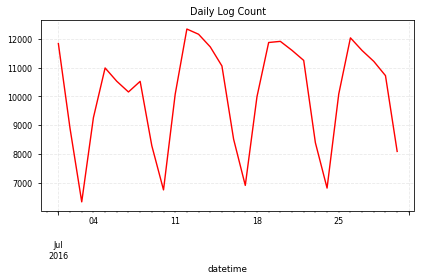

In [106]:
# daily log size
df.groupby("datetime").size().plot(c='r');

plt.title("Daily Log Count")
plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

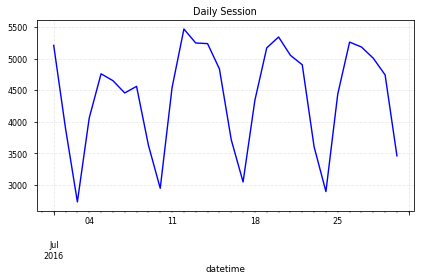

In [107]:
# daily session count => activness index
df.groupby("datetime")['sessionid'].nunique().plot(c='b');

plt.title("Daily Session")
plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

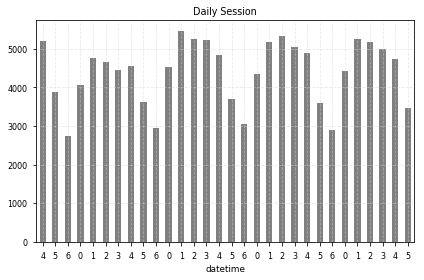

In [108]:
## daily session count (weekofday)
# 0: Monday, 6: Sunday

s = df.groupby("datetime")['sessionid'].nunique()
s.index = s.index.dayofweek

s.plot(color='grey', kind='bar', rot=0);

plt.title("Daily Session")
plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

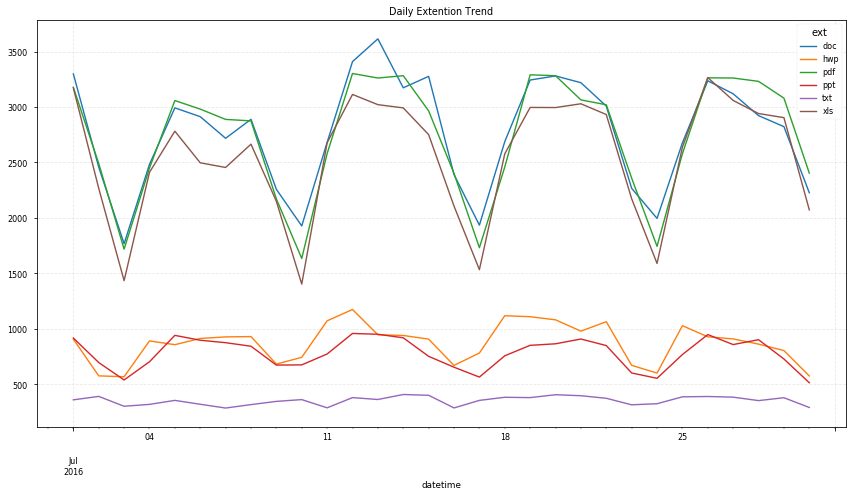

In [109]:
# daily trend by extention
df.groupby(["datetime", "ext"]).size().unstack().dropna(axis=1).plot(figsize=(12,7));

plt.title("Daily Extention Trend")
plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

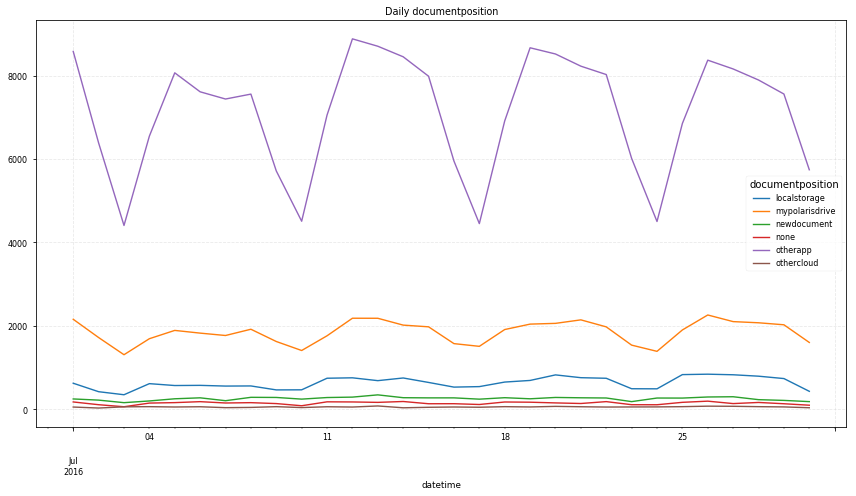

In [110]:
# daily trend by doc position
df.groupby(["datetime", "documentposition"]).size().unstack().dropna(axis=1).plot(figsize=(12,7));

plt.title("Daily documentposition")
plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

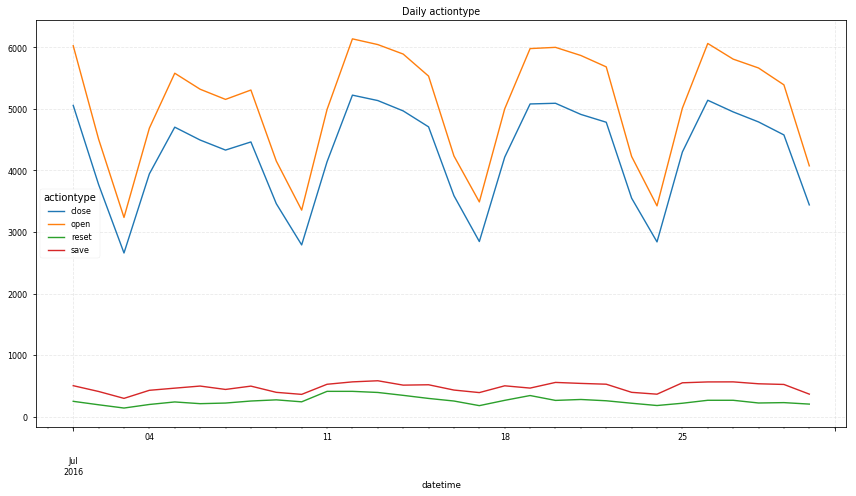

In [111]:
# daily trend by action type
df.groupby(["datetime", "actiontype"]).size().unstack().dropna(axis=1).plot(figsize=(12,7));

plt.title("Daily actiontype")
plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

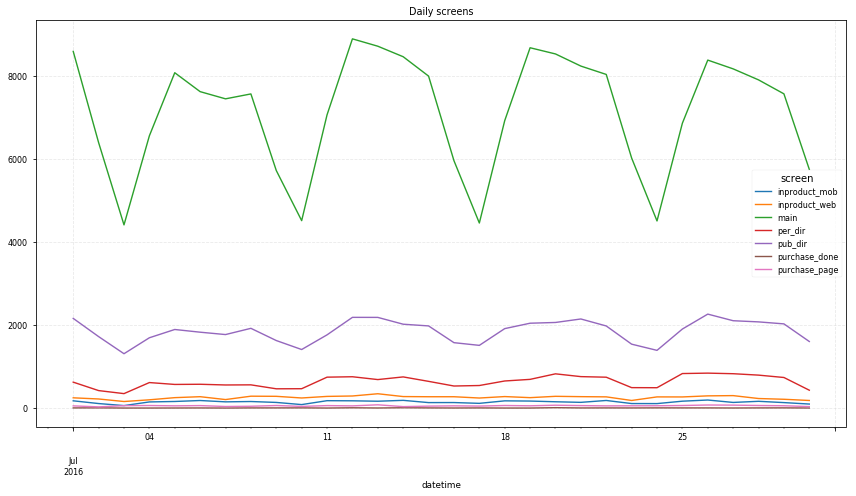

In [112]:
# daily trend by screen name
df.groupby(["datetime", "screen"]).size().unstack().fillna(0).astype(int).plot(figsize=(12,7));

plt.title("Daily screens")
plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

In [113]:
# heat map
screens = df.groupby(["datetime", "screen"])['sessionid'].nunique().unstack().fillna(0).astype(int)

# cols order change
screens = screens[screens.mean().sort_values(ascending=False).index]

screens[:10]

screen,main,pub_dir,per_dir,inproduct_web,inproduct_mob,purchase_page,purchase_done
datetime,,,,,,,
2016-07-01,3911,1112,381,178,143,24,2
2016-07-02,2935,888,251,140,92,15,2
2016-07-03,2005,648,197,85,50,33,0
2016-07-04,3016,847,349,120,124,32,0
2016-07-05,3631,942,354,159,127,28,1
2016-07-06,3525,949,374,163,148,31,1
2016-07-07,3433,896,324,133,127,18,0
2016-07-08,3477,961,339,169,127,23,2
2016-07-09,2605,865,277,178,110,30,2


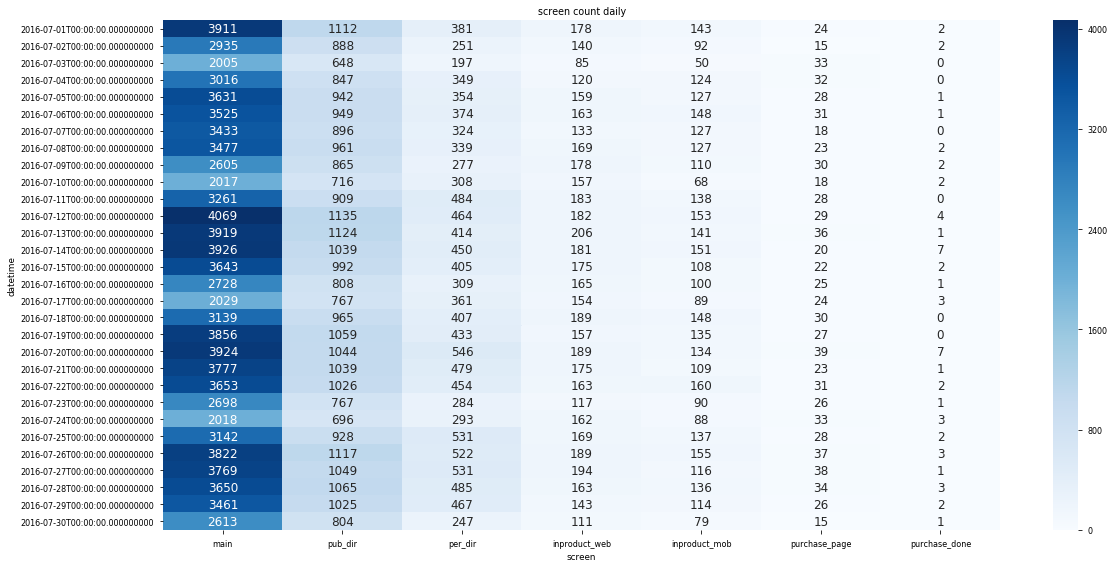

In [114]:
plt.subplots(figsize=(17,8))

sns.heatmap(screens, annot=True, fmt="d", annot_kws={"size": 12}, cmap='Blues');

plt.title("screen count daily")
plt.tight_layout()

### 3.2 Pivoting 을 통한 변수별 특성 탐색
- unstack, stack, pivot_table 과 같은 pandas 함수를 이용해, 다양한 각도에서 데이터 탐색

In [115]:
df.groupby(["ext", "actiontype"])['sessionid'].nunique().unstack().fillna(0)

actiontype,close,export,open,reset,save
ext,,,,,
doc,29182.0,41.0,34855.0,2385.0,4386.0
hwp,9600.0,6.0,11551.0,486.0,1555.0
jpg,0.0,11.0,0.0,0.0,0.0
pdf,32560.0,6.0,38165.0,2273.0,765.0
ppt,8754.0,5.0,10531.0,581.0,623.0
sheet,1.0,0.0,3.0,1.0,0.0
txt,4288.0,1.0,4910.0,251.0,450.0
word,1.0,0.0,1.0,0.0,0.0
xls,28415.0,13.0,33920.0,1608.0,4901.0


In [116]:
df.groupby(["ext", "actiontype"])['sessionid'].nunique().unstack().fillna(0).apply(lambda x: x/x.sum()*100).round(2)

actiontype,close,export,open,reset,save
ext,,,,,
doc,25.87,49.40,26.02,31.44,34.59
hwp,8.51,7.23,8.62,6.41,12.26
jpg,0.00,13.25,0.00,0.00,0.00
pdf,28.86,7.23,28.49,29.97,6.03
ppt,7.76,6.02,7.86,7.66,4.91
sheet,0.00,0.00,0.00,0.01,0.00
txt,3.80,1.20,3.67,3.31,3.55
word,0.00,0.00,0.00,0.00,0.00
xls,25.19,15.66,25.33,21.20,38.65


In [117]:
df.groupby(["ext", "documentposition"])['sessionid'].nunique().unstack().fillna(0).apply(lambda x: x/x.sum()*100).round(2)

documentposition,localstorage,mypolarisdrive,newdocument,none,otherapp,othercloud,shareddocument
ext,,,,,,,
doc,24.10,27.00,52.55,21.12,26.02,22.88,33.33
hwp,18.79,8.80,15.77,29.67,7.88,5.69,26.32
jpg,0.07,0.00,0.00,0.00,0.00,0.00,0.00
pdf,16.20,18.64,0.10,12.29,32.31,13.70,15.79
ppt,9.08,9.84,12.15,9.73,7.05,4.53,15.79
sheet,0.00,0.01,0.00,0.03,0.00,0.00,0.00
txt,5.98,5.49,2.43,4.85,2.93,2.21,0.00
word,0.00,0.00,0.00,0.03,0.00,0.00,0.00
xls,25.78,30.20,17.00,22.28,23.81,50.99,8.77


### 3.3 변수별 분포 및 상관관계
- 변수별 상관관계/분포를 파악하기 위한 분석단위는?

In [120]:
df.head()

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,open,noview,pdf,ses_0,localstorage,2016-07-18,per_dir
1,close,noview,pdf,ses_0,localstorage,2016-07-18,per_dir
2,open,view,pdf,ses_0,mypolarisdrive,2016-07-18,pub_dir
3,close,view,pdf,ses_0,mypolarisdrive,2016-07-18,pub_dir
4,open,noview,pdf,ses_1,otherapp,2016-07-06,main


In [125]:
ext_by_session = df.query("actiontype == 'open'").groupby(["sessionid", "ext"]).size().unstack().dropna(how='all')

ext_by_session.head()

ext,doc,hwp,pdf,ppt,sheet,txt,word,xls
sessionid,,,,,,,,
ses_0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
ses_1,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
ses_10,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN
ses_100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
ses_1000,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In [126]:
pos_by_session = df.query("actiontype == 'open'").groupby(['sessionid', 'documentposition']).size().unstack().dropna(how='all')

pos_by_session.head()

documentposition,localstorage,mypolarisdrive,newdocument,otherapp,othercloud,shareddocument
sessionid,,,,,,
ses_0,1.0,1.0,NaN,NaN,NaN,NaN
ses_1,NaN,NaN,NaN,1.0,NaN,NaN
ses_10,NaN,1.0,NaN,1.0,NaN,NaN
ses_100,NaN,NaN,NaN,1.0,NaN,NaN
ses_1000,NaN,NaN,NaN,1.0,NaN,NaN


In [127]:
exp_pos = pd.concat([ext_by_session, pos_by_session], axis=1).fillna(0)

exp_pos.head()

,doc,hwp,pdf,ppt,sheet,txt,word,xls,localstorage,mypolarisdrive,newdocument,otherapp,othercloud,shareddocument
sessionid,,,,,,,,,,,,,,
ses_0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
ses_1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
ses_10,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
ses_100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
ses_1000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [128]:
exp_pos.describe()

,doc,hwp,pdf,ppt,sheet,txt,word,xls,localstorage,mypolarisdrive,newdocument,otherapp,othercloud,shareddocument
count,120657.000000,120657.000000,120657.000000,120657.000000,120657.000000,120657.000000,120657.000000,120657.000000,120657.000000,120657.000000,120657.000000,120657.000000,120657.000000,120657.000000
mean,0.338895,0.108315,0.353357,0.100193,0.000025,0.042758,0.000008,0.314578,0.070613,0.212445,0.035240,0.933986,0.005404,0.000439
std,0.586253,0.352749,0.554466,0.347998,0.004986,0.212968,0.002879,0.539943,0.274936,0.467050,0.199376,0.688526,0.080941,0.021346
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,6.000000,6.000000,4.000000,5.000000,1.000000,4.000000,1.000000,7.000000,5.000000,7.000000,4.000000,9.000000,4.000000,2.000000


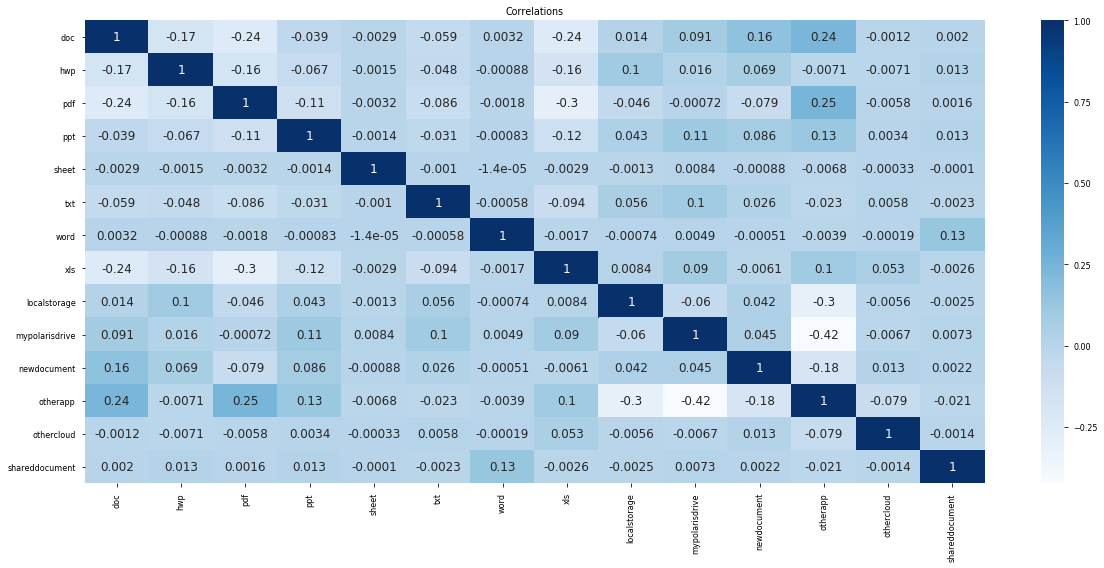

In [129]:
plt.subplots(figsize=(17,8))

sns.heatmap(exp_pos.corr(), annot=True, annot_kws={"size": 12}, cmap='Blues');

plt.title("Correlations")
plt.tight_layout()

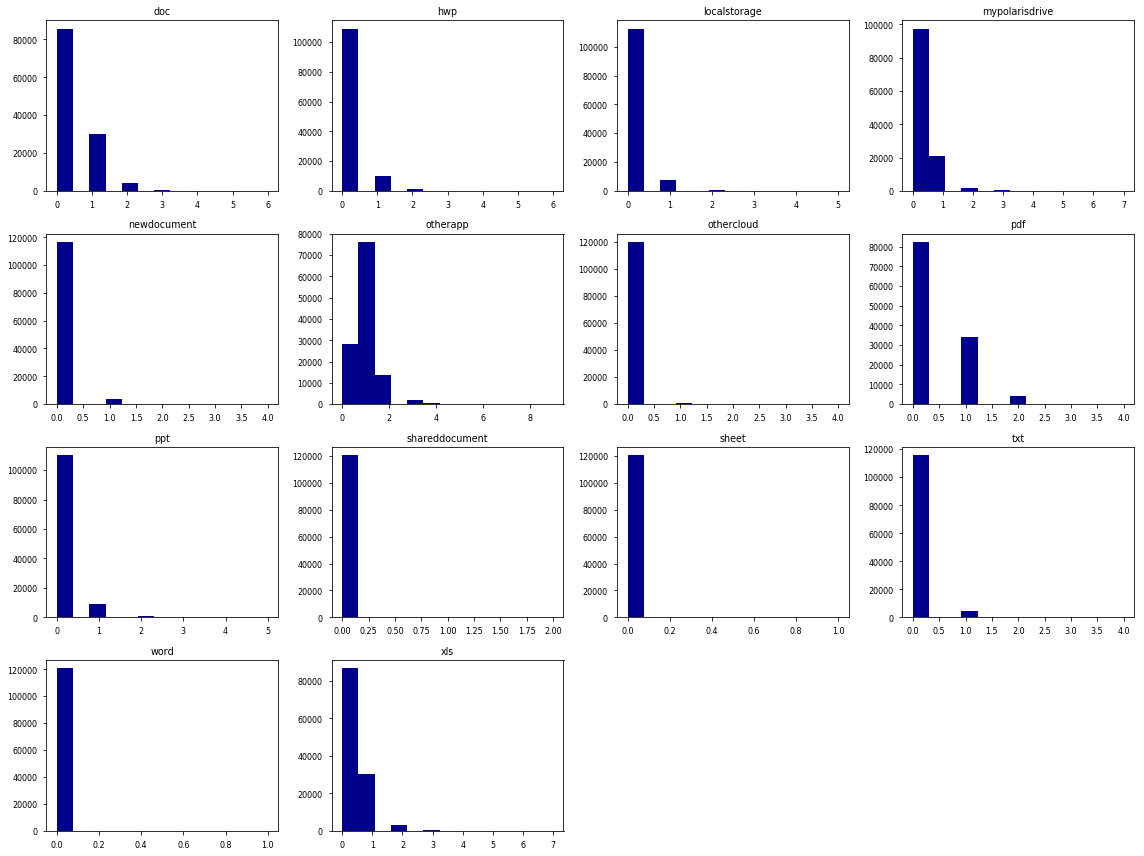

In [130]:
exp_pos.hist(bins=13, color='darkblue', figsize=(16,12), grid=False);

plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

### 3.4 구간별 전환율 (Funnel) Daily Trend

In [131]:
screens.head(10) # daily session count by screen

screen,main,pub_dir,per_dir,inproduct_web,inproduct_mob,purchase_page,purchase_done
datetime,,,,,,,
2016-07-01,3911,1112,381,178,143,24,2
2016-07-02,2935,888,251,140,92,15,2
2016-07-03,2005,648,197,85,50,33,0
2016-07-04,3016,847,349,120,124,32,0
2016-07-05,3631,942,354,159,127,28,1
2016-07-06,3525,949,374,163,148,31,1
2016-07-07,3433,896,324,133,127,18,0
2016-07-08,3477,961,339,169,127,23,2
2016-07-09,2605,865,277,178,110,30,2


In [132]:
# mean of each columns
conver_cnt = screens.mean().apply(lambda x: int(x)).sort_values(ascending=False)

conver_cnt

screen
main             3255
pub_dir           939
per_dir           390
inproduct_web     161
inproduct_mob     119
purchase_page      27
purchase_done       1
dtype: int64

In [133]:
# average conversion rate
try:
    for i in range(len(conver_cnt)):
        print((conver_cnt[i+1] / (conver_cnt[i] * 1.0) * 100).round(2))

except IndexError, e:
    print(e)

28.85
41.53
41.28
73.91
22.69
3.7
index out of bounds


In [134]:
# another option for gettig average conversion rate
conver_rt = [(conver_cnt[i+1] / (conver_cnt[i] * 1.0) * 100).round(2) for i in range(len(conver_cnt)) if i < 6]

conver_rt

[28.85, 41.53, 41.28, 73.91, 22.69, 3.7]

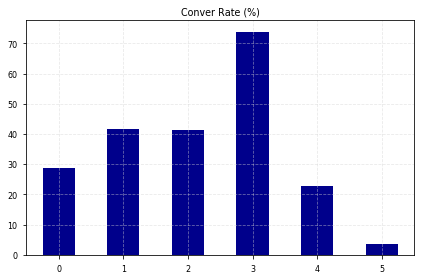

In [135]:
pd.Series(conver_rt).plot(kind='bar', color = 'darkblue', rot=0)

plt.title("Conver Rate (%)")
plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

In [136]:
# create x labels
fun_label = [conver_cnt.index[k] + " > " + conver_cnt.index[k + 1] for k, v in enumerate(conver_cnt.index) if k < 6]

fun_label

['main > pub_dir',
 'pub_dir > per_dir',
 'per_dir > inproduct_web',
 'inproduct_web > inproduct_mob',
 'inproduct_mob > purchase_page',
 'purchase_page > purchase_done']

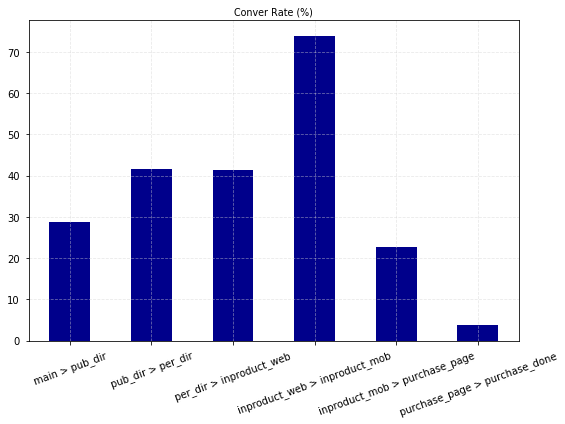

In [137]:
# with revised x labels
pd.Series(conver_rt, index=fun_label).plot(kind='bar', color = 'darkblue', rot=20, figsize=(8,6), fontsize=10)

plt.title("Conver Rate (%)")
plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

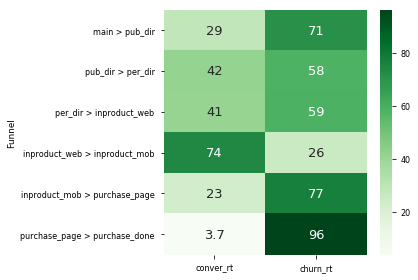

In [138]:
# another visualization
conv_rt_tb = pd.Series(conver_rt, index=fun_label).to_frame()
conv_rt_tb.index.name = 'Funnel'
conv_rt_tb.columns = ['conver_rt']
conv_rt_tb['churn_rt'] = 100 - conv_rt_tb['conver_rt']

sns.heatmap(conv_rt_tb, annot=True, annot_kws={"size": 13}, cmap='Greens');

plt.tight_layout()

### 3.5 중간 정리
- 보고서 공유
- 지표설정 및 대시보드 구축
    - 주요 구간전환율
- A/B Testing
- 개선작업 반복 프로세스

## 4. 클러스터링 For Targeting

### 4.0 심슨의 역설
- http://www.mathpark.com/530

### 4.1 What is K-MEANS?
 1. Select number of clusters, K
 2. Select K points as the initial centroids
 3. Repeat
 4. Form K clusters by assigning all points to the closest centroid
 5. Recompute the centroid of each cluster
 6. Until The centroids don't change 
 
- Reference link: http://rfriend.tistory.com/228 
![imge](https://t1.daumcdn.net/cfile/tistory/2649913A57A572321D) 

In [139]:
df.head()

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,open,noview,pdf,ses_0,localstorage,2016-07-18,per_dir
1,close,noview,pdf,ses_0,localstorage,2016-07-18,per_dir
2,open,view,pdf,ses_0,mypolarisdrive,2016-07-18,pub_dir
3,close,view,pdf,ses_0,mypolarisdrive,2016-07-18,pub_dir
4,open,noview,pdf,ses_1,otherapp,2016-07-06,main


In [201]:
# 확장자만 기준으로 group by sessionid 하여 클러스터링을 위한 전처리 진행
# Note. if 다른 변수가 같이 있다면 scaling 필수
df_ext = df.query("actiontype == 'open'").groupby(["sessionid", "ext"]).size().unstack().fillna(0)

df_ext.head(10)

ext,doc,hwp,pdf,ppt,sheet,txt,word,xls
sessionid,,,,,,,,
ses_0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
ses_1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
ses_10,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
ses_100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
ses_1000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
ses_10000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
ses_100000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
ses_100001,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ses_100002,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [202]:
df_ext_mat = df_ext.as_matrix()

df_ext_mat

array([[0., 0., 2., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 2., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [203]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=4).fit(df_ext_mat)

In [204]:
labels = km.labels_

labels

array([1, 1, 0, ..., 2, 3, 1], dtype=int32)

In [205]:
df_ext['group'] = labels

In [206]:
df_ext.group.value_counts()

1    37156
3    31733
2    30130
0    21638
Name: group, dtype: int64

In [207]:
df_ext_mean = df_ext.groupby("group").mean().round(2)

df_ext_mean

ext,doc,hwp,pdf,ppt,sheet,txt,word,xls
group,,,,,,,,
0,0.00,0.57,0.01,0.40,0.0,0.19,0.0,0.00
1,0.08,0.01,1.12,0.03,0.0,0.01,0.0,0.05
2,1.19,0.00,0.02,0.06,0.0,0.02,0.0,0.01
3,0.06,0.01,0.01,0.02,0.0,0.01,0.0,1.13


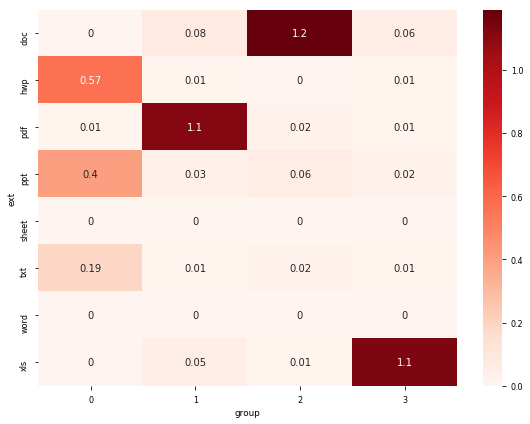

In [208]:
plt.subplots(figsize=(8,6))

sns.heatmap(df_ext_mean.T, annot=True, cmap='Reds')

plt.tight_layout()

In [209]:
df_ext.head()

ext,doc,hwp,pdf,ppt,sheet,txt,word,xls,group
sessionid,,,,,,,,,
ses_0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1
ses_1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
ses_10,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0
ses_100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3
ses_1000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1


####  Note. Labeling 주의

In [210]:
# be careful with the values; the group no. changes randomly
group_name = {0: 'gr_hwp',
              1: 'gr_pdf',
              2: 'gr_doc',
              3: 'gr_xls'}

In [211]:
df_ext['group'] = df_ext['group'].replace(group_name)

In [212]:
df_ext.head()

ext,doc,hwp,pdf,ppt,sheet,txt,word,xls,group
sessionid,,,,,,,,,
ses_0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,gr_pdf
ses_1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,gr_pdf
ses_10,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,gr_hwp
ses_100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,gr_xls
ses_1000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,gr_pdf


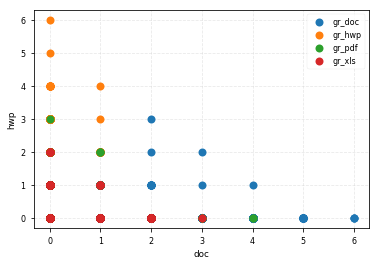

In [213]:
groups = df_ext.groupby("group")

fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.doc, group.hwp, marker='o', linestyle='', ms=8, label=name)
    ax.legend()

plt.xlabel("doc")
plt.ylabel("hwp")
plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.show()

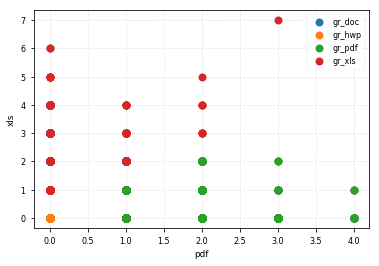

In [214]:
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.pdf, group.xls, marker='o', linestyle='', ms=8, label=name)
    ax.legend()

plt.xlabel("pdf")
plt.ylabel("xls")
plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.show()

In [215]:
df_open = df.query("actiontype == 'open'")

df_open.head(10)

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen
0,open,noview,pdf,ses_0,localstorage,2016-07-18,per_dir
2,open,view,pdf,ses_0,mypolarisdrive,2016-07-18,pub_dir
4,open,noview,pdf,ses_1,otherapp,2016-07-06,main
7,open,noview,pdf,ses_2,otherapp,2016-07-20,main
8,open,noview,pdf,ses_3,otherapp,2016-07-28,main
10,open,view,pdf,ses_3,otherapp,2016-07-28,main
11,open,noview,pdf,ses_4,otherapp,2016-07-19,main
14,open,view,pdf,ses_5,mypolarisdrive,2016-07-24,pub_dir
16,open,noview,pdf,ses_6,otherapp,2016-07-24,main
18,open,noview,hwp,ses_7,otherapp,2016-07-11,main


In [216]:
df_ext.group.head()

sessionid
ses_0       gr_pdf
ses_1       gr_pdf
ses_10      gr_hwp
ses_100     gr_xls
ses_1000    gr_pdf
Name: group, dtype: object

In [217]:
df_cluster = df_open.merge(df_ext[['group']].reset_index(), on='sessionid', how='left')

df_cluster.head(10)

,actiontype,ismydoc,ext,sessionid,documentposition,datetime,screen,group
0,open,noview,pdf,ses_0,localstorage,2016-07-18,per_dir,gr_pdf
1,open,view,pdf,ses_0,mypolarisdrive,2016-07-18,pub_dir,gr_pdf
2,open,noview,pdf,ses_1,otherapp,2016-07-06,main,gr_pdf
3,open,noview,pdf,ses_2,otherapp,2016-07-20,main,gr_pdf
4,open,noview,pdf,ses_3,otherapp,2016-07-28,main,gr_pdf
5,open,view,pdf,ses_3,otherapp,2016-07-28,main,gr_pdf
6,open,noview,pdf,ses_4,otherapp,2016-07-19,main,gr_pdf
7,open,view,pdf,ses_5,mypolarisdrive,2016-07-24,pub_dir,gr_pdf
8,open,noview,pdf,ses_6,otherapp,2016-07-24,main,gr_pdf
9,open,noview,hwp,ses_7,otherapp,2016-07-11,main,gr_xls


In [218]:
#define a function to get conversion rates
def conv_rt_by_grp(gr):
    df_gr_screen = df_cluster[df_cluster['group'] == gr]\
                     .groupby(["datetime", "screen"])['sessionid']\
                     .nunique().unstack().fillna(0).astype(int)
            
    conver_cnt = df_gr_screen.mean().apply(lambda x: int(x)).sort_values(ascending=False)
    conver_rt = [conver_cnt[i+1] / (conver_cnt[i] * 1.0) * 100 for i in range(len(conver_cnt)) if i < 5]
    fun_label = [conver_cnt.index[k] + " > " + conver_cnt.index[k + 1] for k, v in enumerate(conver_cnt.index) if k < 5]
    conver_rt = pd.Series(conver_rt, index=fun_label).fillna(0)
    
    return conver_rt

In [219]:
conv_rt_pdf = conv_rt_by_grp('gr_pdf')

conv_rt_pdf

main > pub_dir                   16.003700
pub_dir > per_dir                28.901734
per_dir > inproduct_web          14.000000
inproduct_web > purchase_page    42.857143
purchase_page > purchase_done     0.000000
dtype: float64

In [220]:
conv_rt_doc = conv_rt_by_grp('gr_doc')
conv_rt_doc

main > pub_dir                   24.675325
pub_dir > inproduct_web          35.263158
inproduct_web > per_dir          88.059701
per_dir > purchase_page           3.389831
purchase_page > purchase_done     0.000000
dtype: float64

In [221]:
conv_rt_xls = conv_rt_by_grp('gr_xls')
conv_rt_xls

main > pub_dir                   33.377660
pub_dir > per_dir                27.490040
per_dir > inproduct_web          34.782609
inproduct_web > purchase_page    45.833333
purchase_page > purchase_done     0.000000
dtype: float64

In [222]:
conv_rt_hwp = conv_rt_by_grp('gr_hwp')
conv_rt_hwp

main > pub_dir                   32.032854
pub_dir > per_dir                55.128205
per_dir > inproduct_web          38.372093
inproduct_web > purchase_page     6.060606
purchase_page > purchase_done     0.000000
dtype: float64

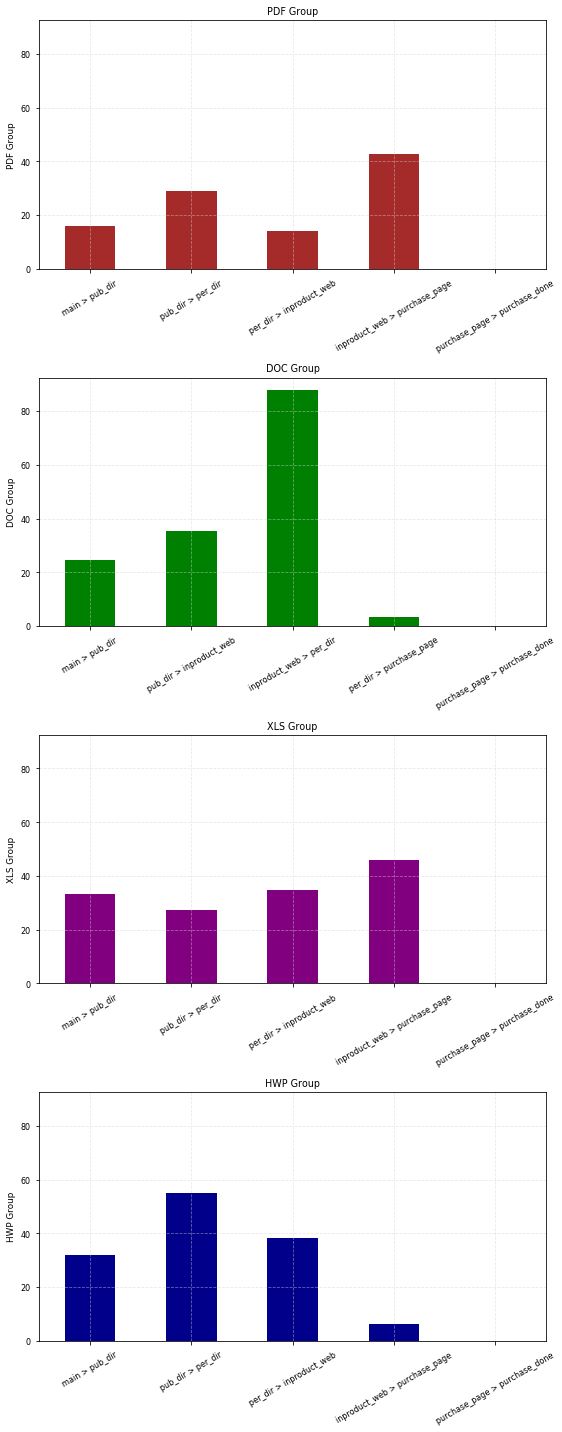

In [223]:
fig, ax = plt.subplots(4, 1, figsize=(8,20), sharey=True)

conv_rt_pdf.plot(kind='bar', ax=ax[0], color = 'brown', rot=30)
ax[0].set_title('PDF Group')
ax[0].set_ylabel('PDF Group')
ax[0].grid(color='lightgrey', alpha=0.5, linestyle='--')

conv_rt_doc.plot(kind='bar', ax=ax[1], color = 'green', rot=30)
ax[1].set_ylabel('DOC Group')
ax[1].set_title('DOC Group')
ax[1].grid(color='lightgrey', alpha=0.5, linestyle='--')

conv_rt_xls.plot(kind='bar', ax=ax[2], color = 'purple', rot=30)
ax[2].set_ylabel('XLS Group')
ax[2].set_title('XLS Group')
ax[2].grid(color='lightgrey', alpha=0.5, linestyle='--')

conv_rt_hwp.plot(kind='bar', ax=ax[3], color = 'darkblue', rot=30)
ax[3].set_ylabel('HWP Group')
ax[3].set_title('HWP Group')
ax[3].grid(color='lightgrey', alpha=0.5, linestyle='--')

plt.tight_layout()

In [224]:
# 그룹별 평균 전환율
gr_pdf_avg = conv_rt_pdf.replace(0, np.nan).mean()
gr_doc_avg = conv_rt_doc.replace(0, np.nan).mean()
gr_xls_avg = conv_rt_xls.replace(0, np.nan).mean()
gr_hwp_avg = conv_rt_hwp.replace(0, np.nan).mean()

print("pdf", gr_pdf_avg)
print("doc", gr_doc_avg)
print("xls", gr_xls_avg)
print("hpw", gr_hwp_avg)

('pdf', 25.44064430967748)
('doc', 37.84700364276835)
('xls', 35.37091036102276)
('hpw', 32.898439605378144)


In [225]:
print(conv_rt_pdf)

main > pub_dir                   16.003700
pub_dir > per_dir                28.901734
per_dir > inproduct_web          14.000000
inproduct_web > purchase_page    42.857143
purchase_page > purchase_done     0.000000
dtype: float64


In [226]:
# 가중치 임의 설정
weights = [1, 1.3, 1.5, 2, 2.5]

# 가중 평균
def weight_avg(gr):
    w_avg = (gr.values * weights).sum() / len(gr)
    return w_avg

In [227]:
gr_pdf_w = weight_avg(conv_rt_pdf)
gr_doc_w = weight_avg(conv_rt_doc)
gr_xls_w = weight_avg(conv_rt_xls)
gr_hwp_w = weight_avg(conv_rt_hwp)

print("pdf:", gr_pdf_w)
print("doc:", gr_doc_w)
print("xls:", gr_xls_w)
print("hwp:", gr_hwp_w)

('pdf:', 32.05804806541333)
('doc:', 41.87732863884754)
('xls:', 42.59105821548833)
('hwp:', 34.67577450644162)


In [228]:
avg_df = pd.DataFrame(list(zip([gr_pdf_avg, gr_doc_avg, gr_xls_avg, gr_hwp_avg],\
                                   [gr_pdf_w, gr_doc_w, gr_xls_w, gr_hwp_w])), \
                                   columns = ['mean', 'wg_mean'],\
                                   index = ['gr_pdf', 'gr_doc', 'gr_xls', 'gr_hwp'])

avg_df

,mean,wg_mean
gr_pdf,25.440644,32.058048
gr_doc,37.847004,41.877329
gr_xls,35.370910,42.591058
gr_hwp,32.898440,34.675775


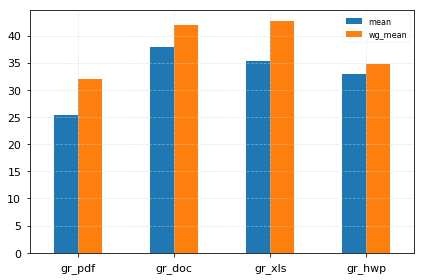

In [229]:
avg_df.plot(kind='bar', fontsize=11, rot=0)

plt.grid(color='lightgrey', alpha=0.5, linestyle='--')
plt.tight_layout()

## 5. 리포트 작성
- 리포트 작성 페이지
    - https://wikidocs.net/16577
- 리포트 작성시 참고사항
    - https://wikidocs.net/16561